<a href="https://colab.research.google.com/github/ognjenMagicni/Machine-Learning-Project/blob/main/ProjekatMOMU1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import kagglehub
path = kagglehub.dataset_download("fedesoriano/stellar-classification-dataset-sdss17")
print("Path to dataset files:", path)
import pandas as pd
df = pd.read_csv(path+'/star_classification.csv')

100%|██████████| 6.89M/6.89M [00:00<00:00, 26.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/stellar-classification-dataset-sdss17/versions/1


#Funkcije koje će se u nastavku koristiti

In [3]:
def model_results(y_test,y_pred,t):
  print('Vrijeme za koje je bilo neophodno da se iztrenira model: ',t,'s')
  acc = metrics.accuracy_score(y_test,y_pred)
  report = metrics.classification_report(y_test, y_pred)
  conf_mat = metrics.confusion_matrix(y_test, y_pred)
  print('Accuracy:',acc)
  print(report)
  print('Confusion matrix:')
  print(conf_mat)

#Predprocesiranje


##Uklanjanje obeležja
Obeležja 'obj_ID','run_ID','rerun_ID','cam_col','field_ID','fiber_ID','MJD','spec_obj_ID' su uklonjena jer njihove vrijednosti ne utiču na klasifikaciju nebeskih tijela.

Baza nema „null vrijednosti“, ali ima uzorak čije vrednosti obeležja „u“ odstupa mnogo u odnosu na ostale vrijednosti. Vrednost je -9999, gdje je prosjek preko 21, a standardno odstupanje preko 31. Uzorak je uklonjen.

In [4]:
df.drop(columns=['obj_ID','run_ID','rerun_ID','cam_col','field_ID','fiber_ID','MJD','spec_obj_ID','plate'],inplace=True)
df = df.loc[ df['u']!=-9999 ]

##Raspodjela obeležja
Sledeće slike pokazuju gustinu raspodjele vjerovatnoća obeležja. Možemo vidjeti da li ima outlinera ili drugih anomalija. Međutim, nema ih.

In [5]:
x = df.drop(columns = ['class'])
y = df['class']

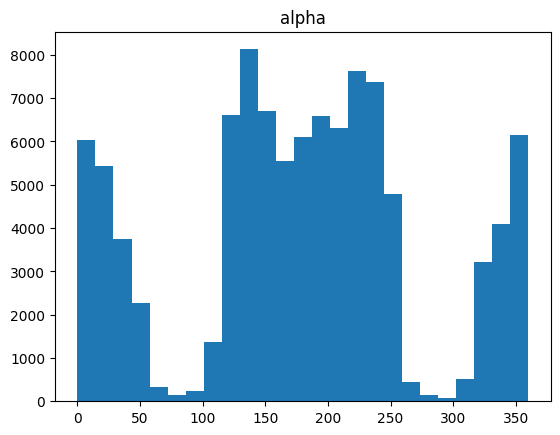

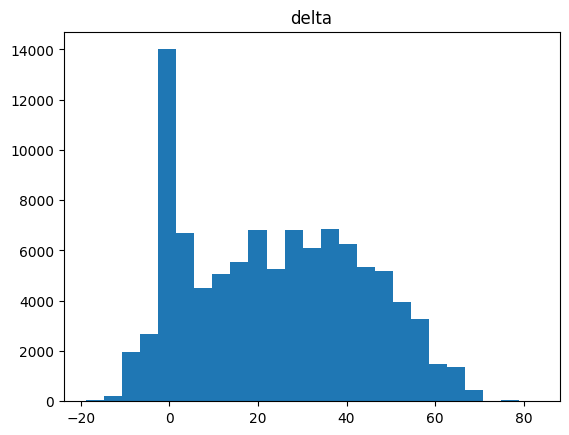

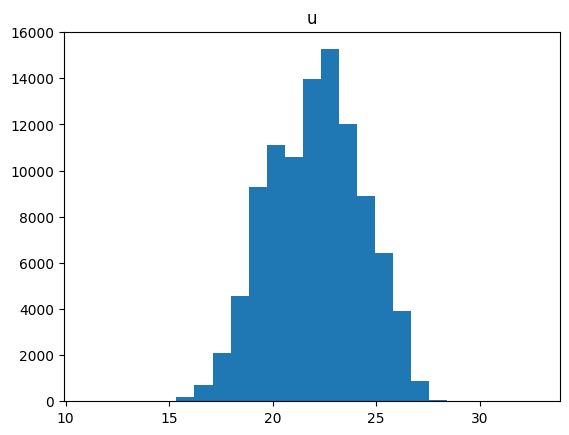

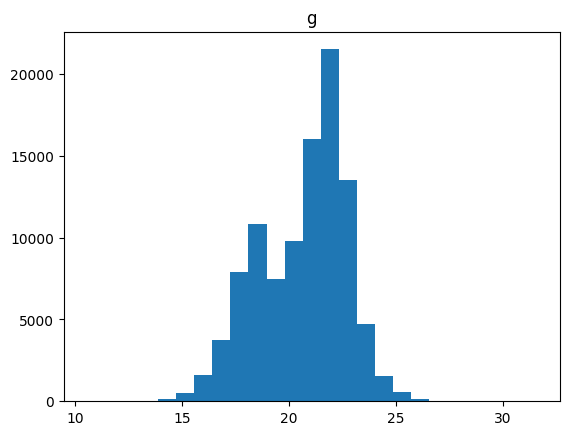

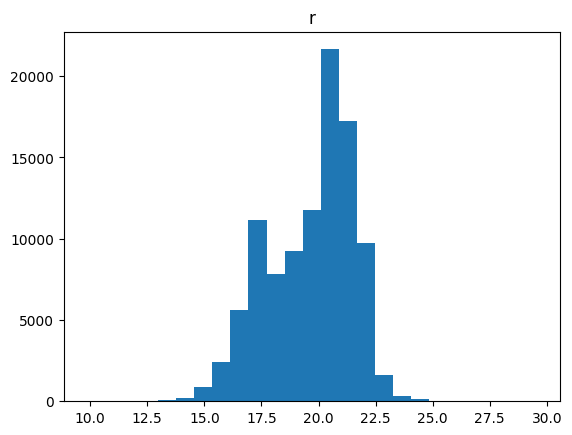

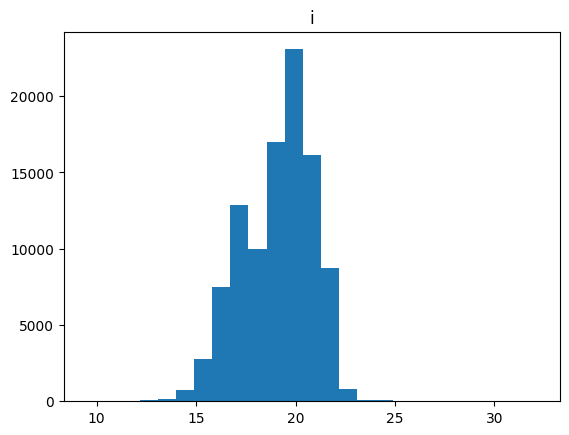

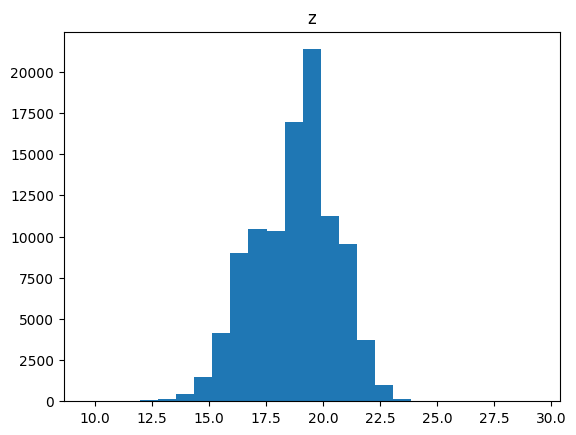

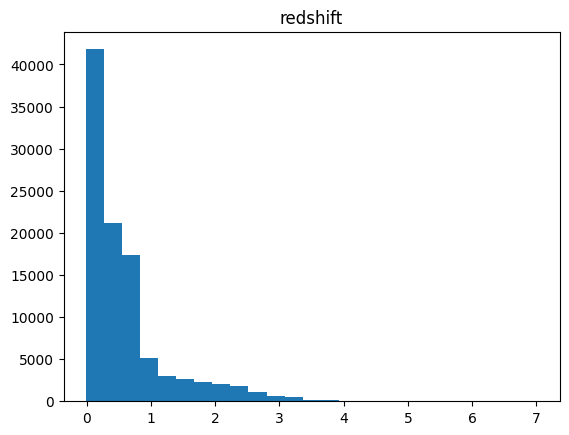

In [6]:
from matplotlib import pyplot as plt
for column in x:
  plt.hist(df[column],bins=25)
  plt.title(column)
  plt.show()

Naredne slike pokazuju raspodjele obeležja za različite klase

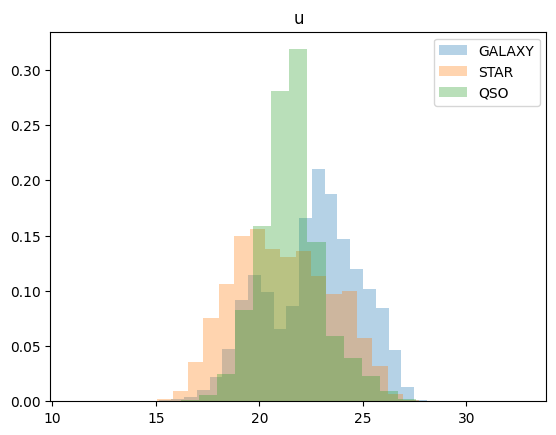

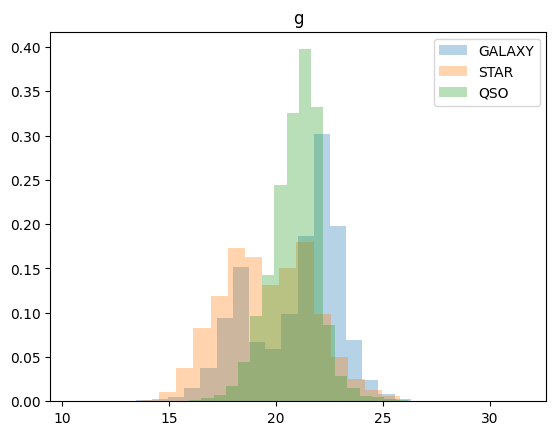

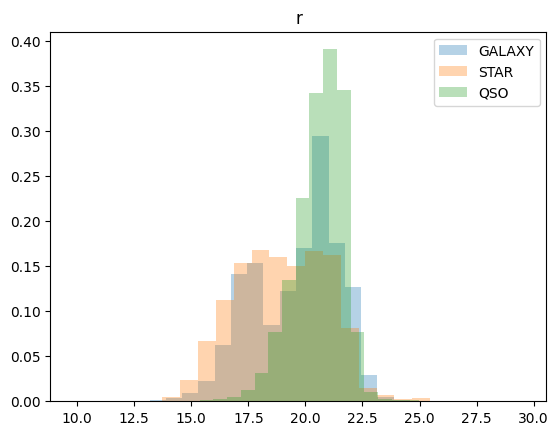

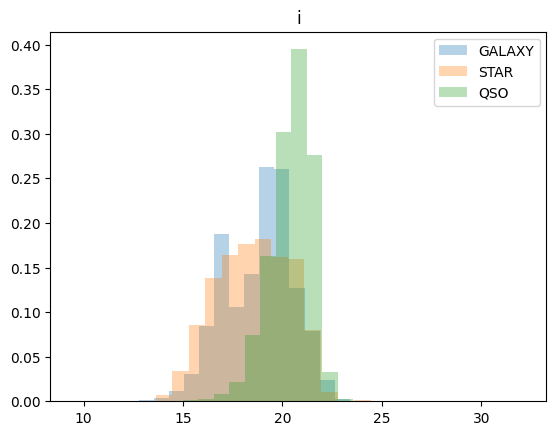

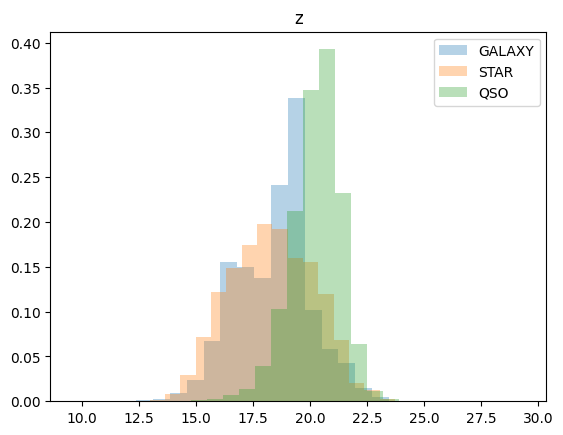

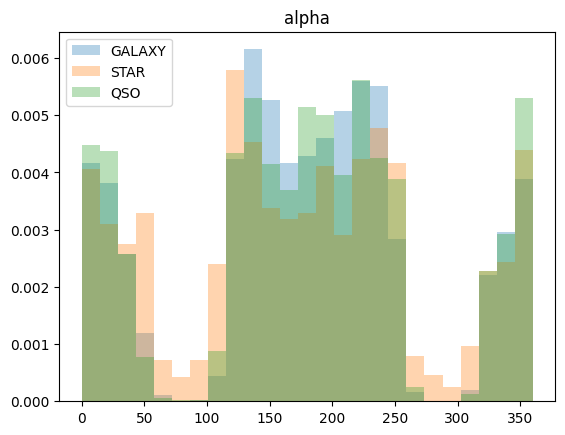

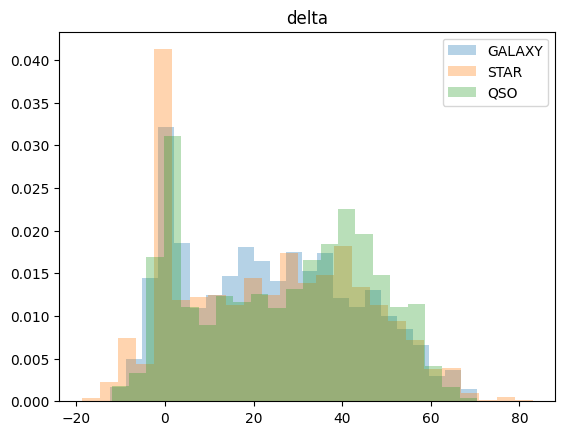

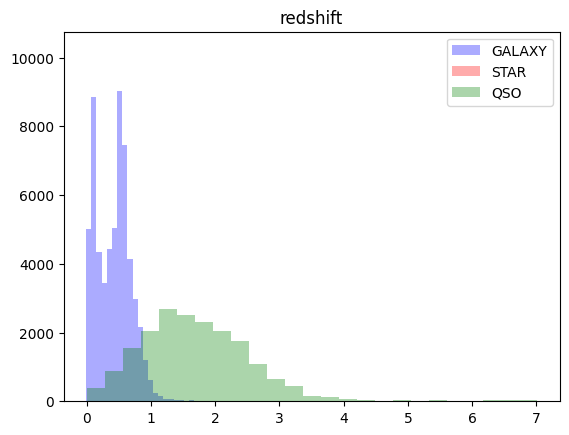

In [7]:
lista = ['u','g','r','i','z','alpha','delta']
for l in lista:
  plt.figure()
  plt.hist(df.loc[df['class']=='GALAXY',l],bins=25,alpha=0.33,density=True,label='GALAXY')
  plt.hist(df.loc[df['class']=="STAR",l],bins=25,alpha=0.33,density=True,label='STAR')
  plt.hist(df.loc[df['class']=="QSO",l],bins=25,alpha=0.33,density=True,label='QSO')
  plt.title(l)
  plt.legend()
  plt.show()

plt.hist(df.loc[df['class']=='GALAXY','redshift'],bins=25,alpha=0.33,color='blue',label='GALAXY')
plt.hist(df.loc[df['class']=='STAR','redshift'],bins=25,alpha=0.33,color='red',label='STAR')
plt.hist(df.loc[df['class']=='QSO','redshift'],bins=25,alpha=0.33,color='green',label='QSO')
plt.title('redshift')
plt.legend()
plt.show()

Vidimo da su sve raspodjele obeležja različitih klasa slične, osim u slučaju sa "redshift"


##Matrica korelacija

<Axes: >

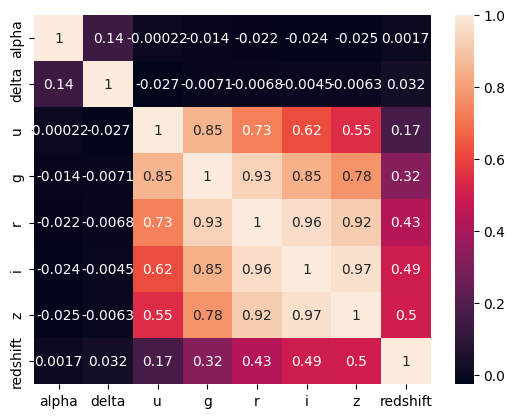

In [8]:
import seaborn as sb

matrix_corr = x.corr()
sb.heatmap(matrix_corr,annot=True)

Možemo uočiti veliku korelisanost između z, u, i, r, g obeležja dok su svi ostali nezavisni

##Konačna obeležja

In [9]:
x = df.drop(columns = ['class'])
y = df['class']

##Dobri vektori
Pokušaćemo da uvidimo koja dva obeležja međusobno imaju dobru diskriminativnu informisanost, odnosno da li su dobri vektori

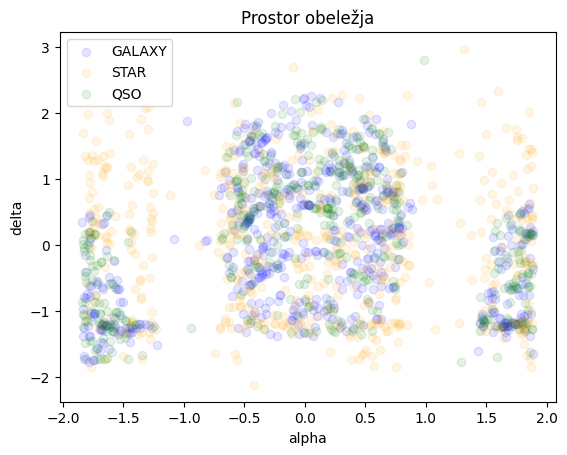

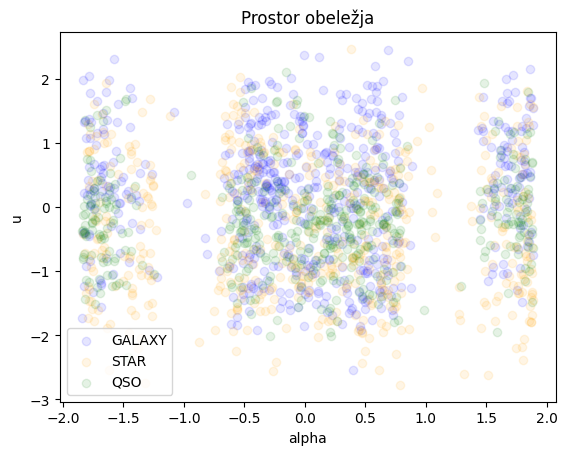

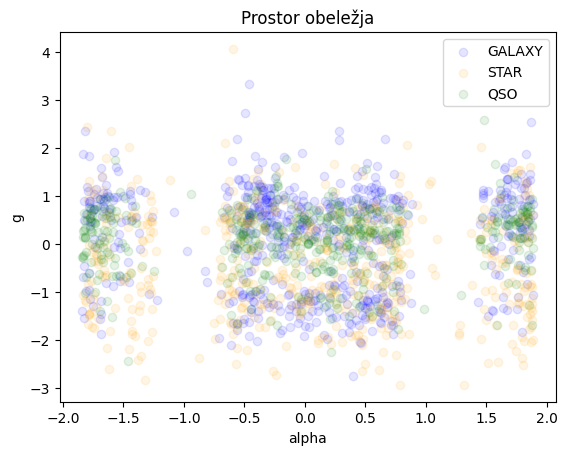

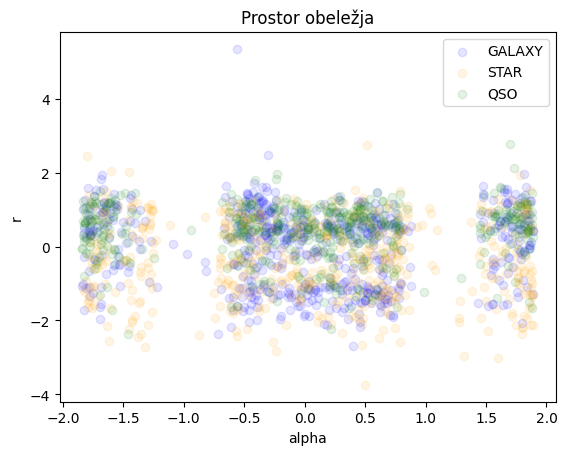

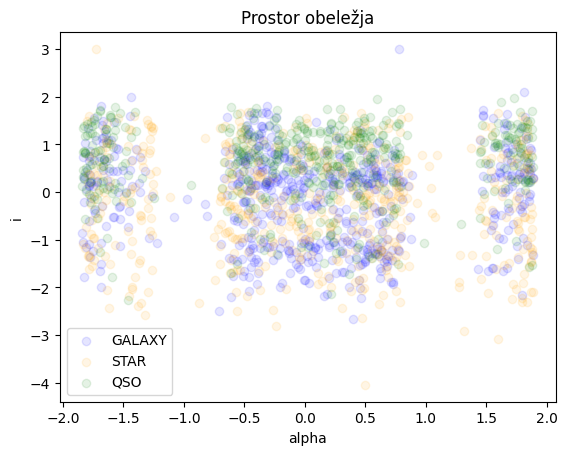

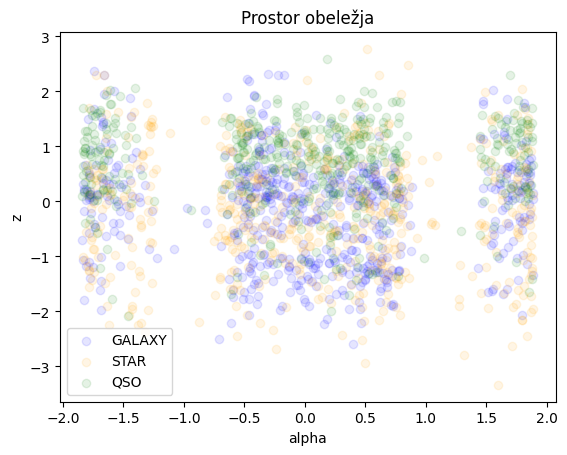

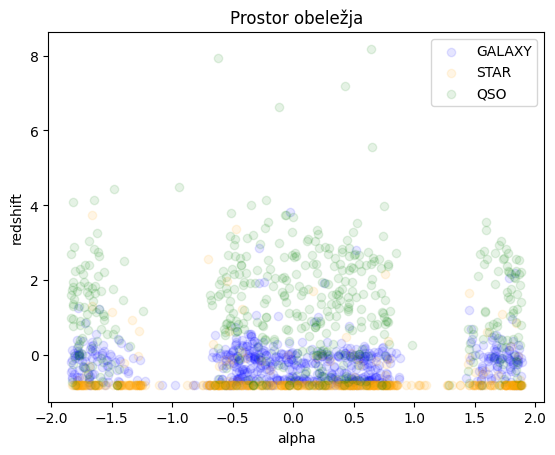

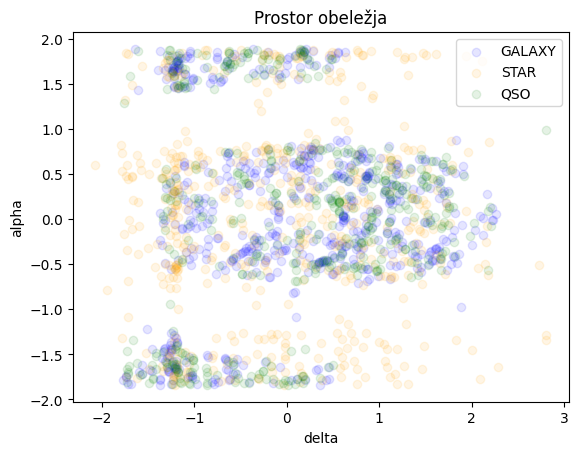

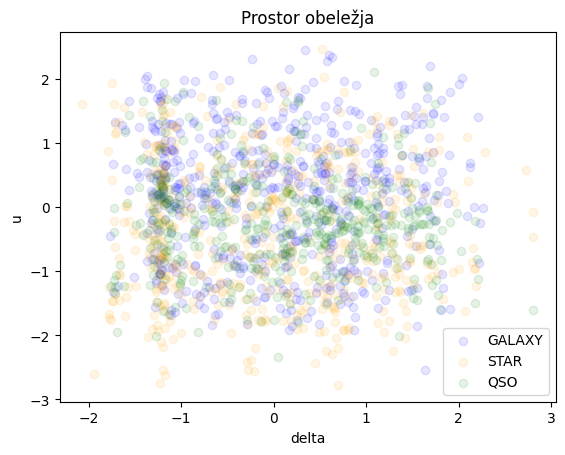

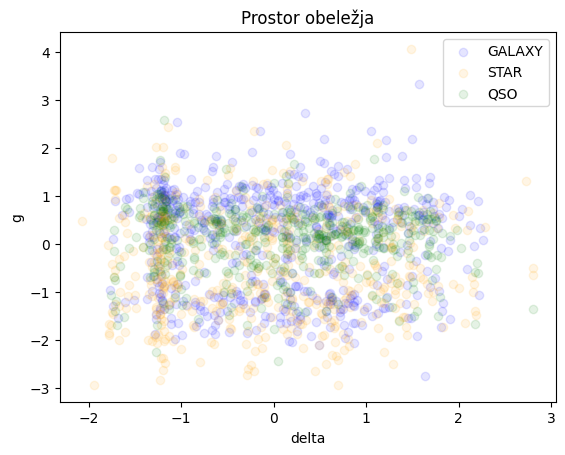

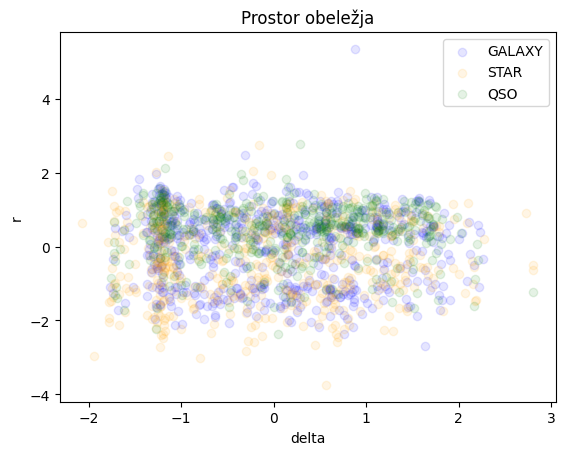

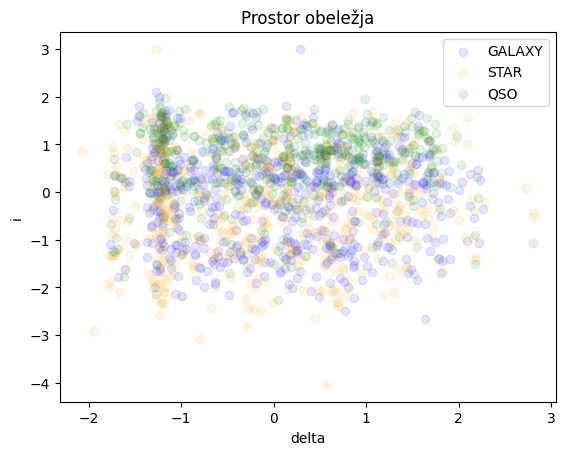

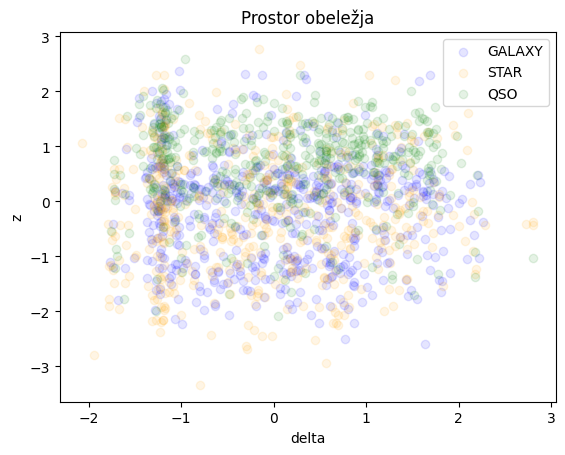

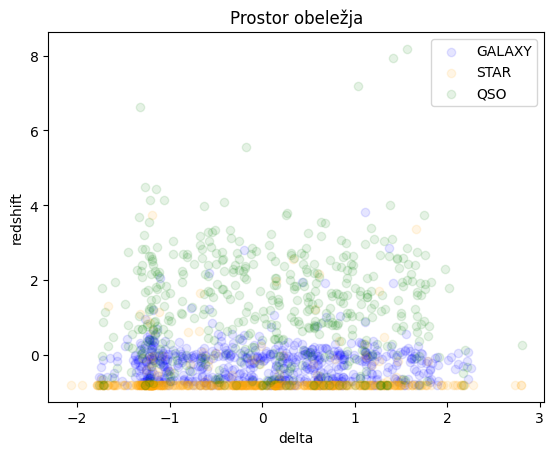

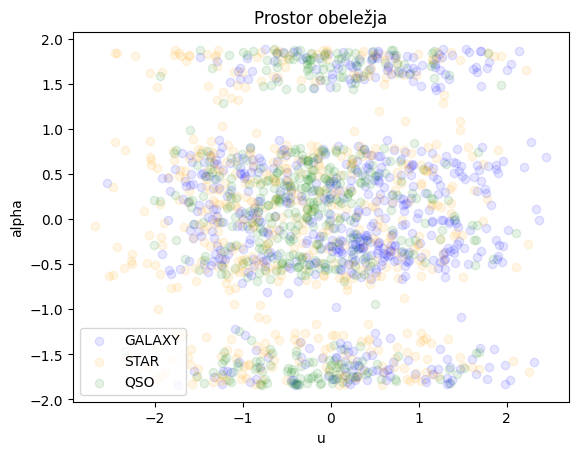

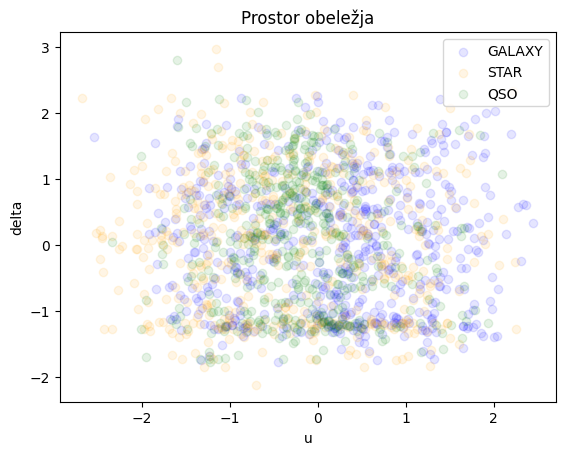

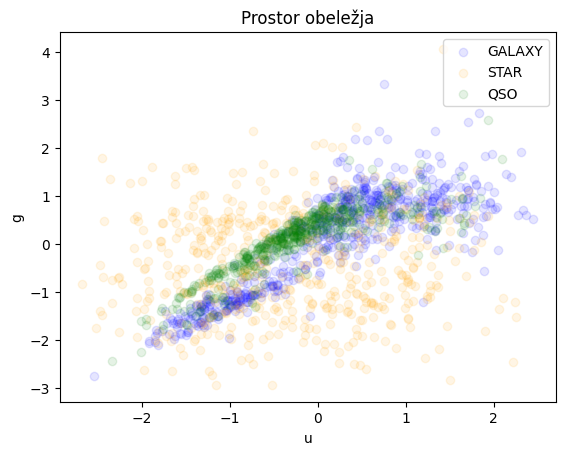

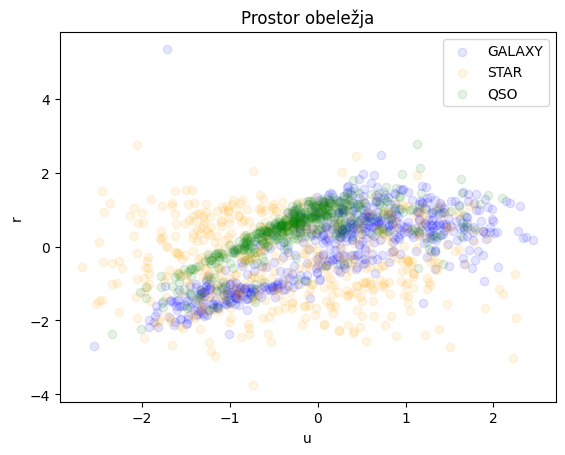

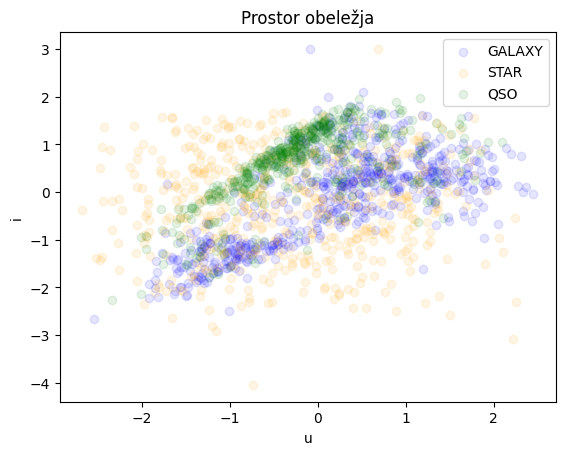

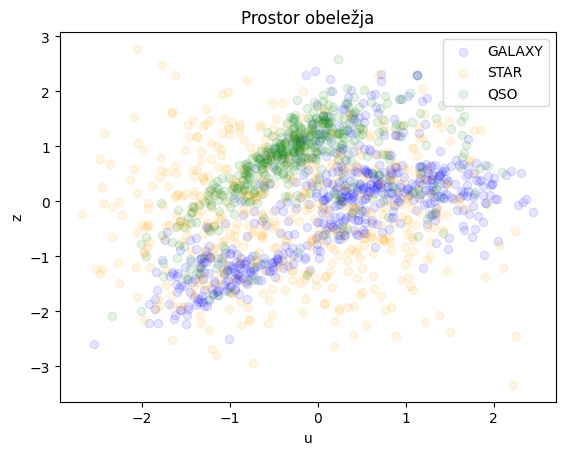

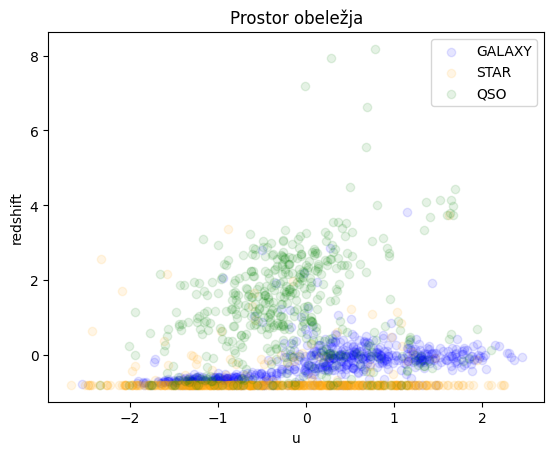

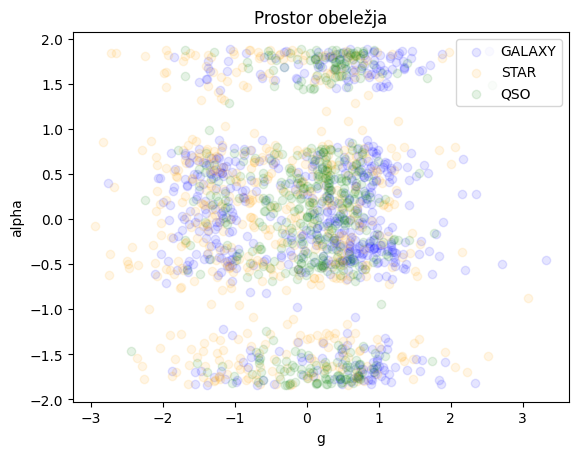

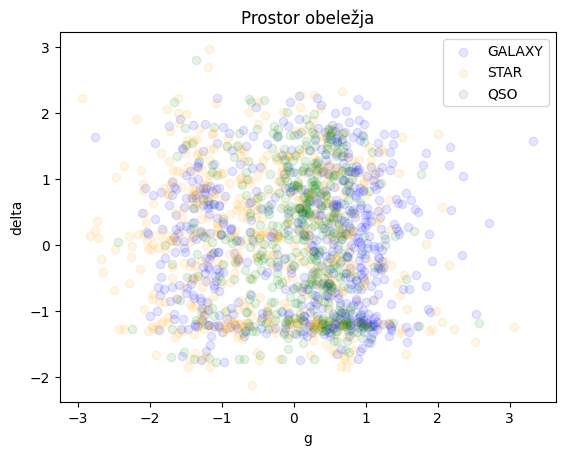

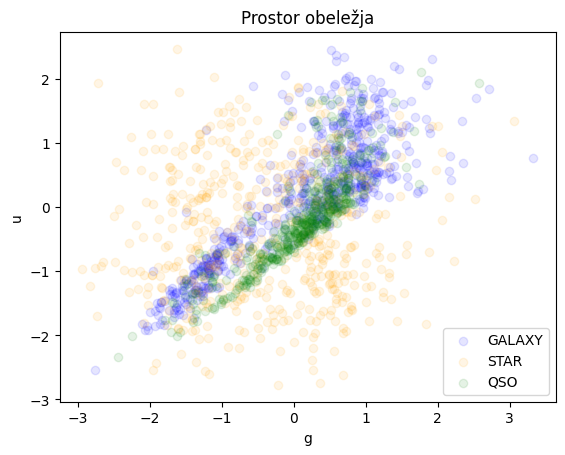

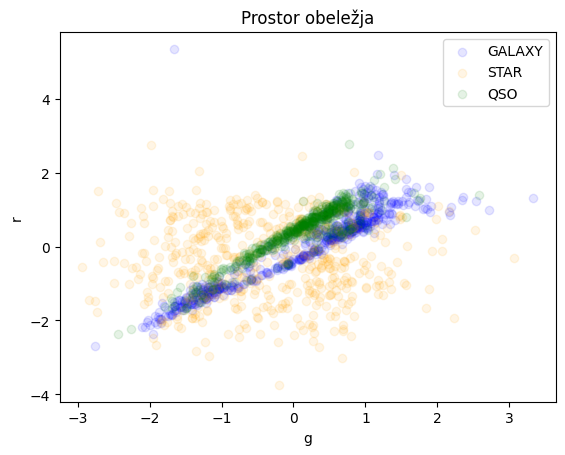

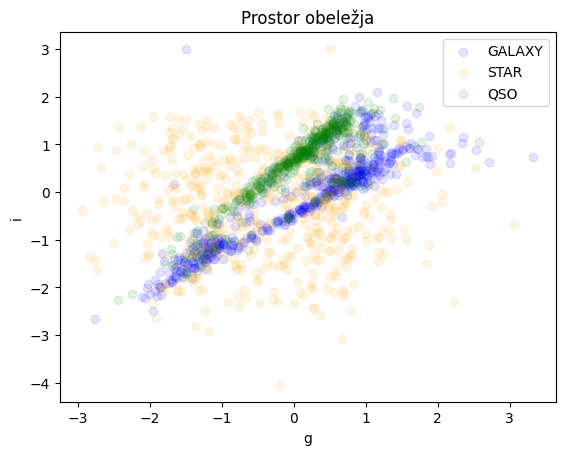

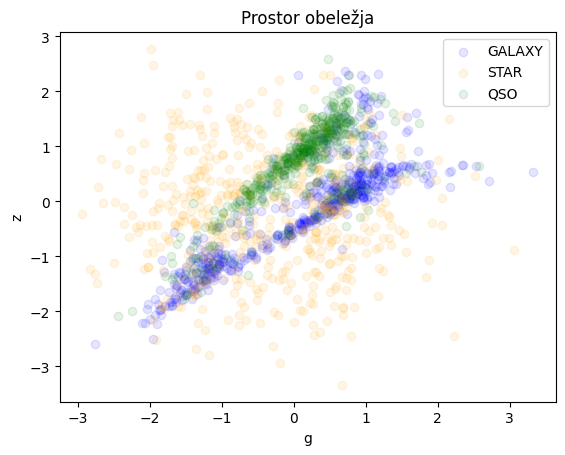

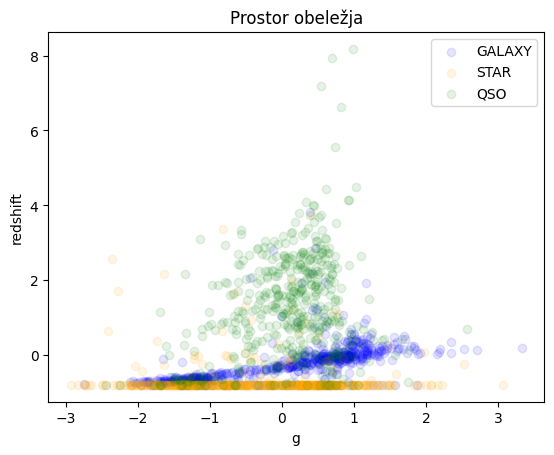

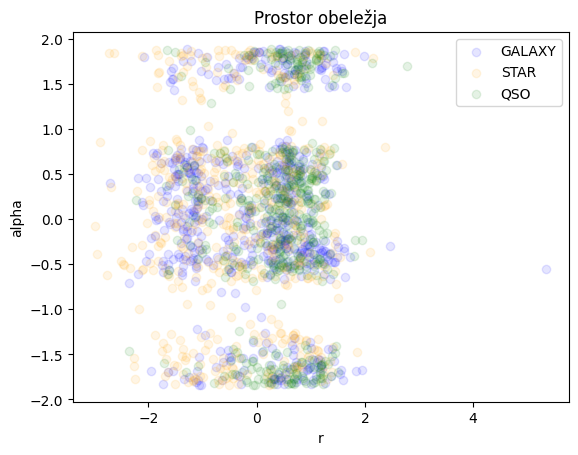

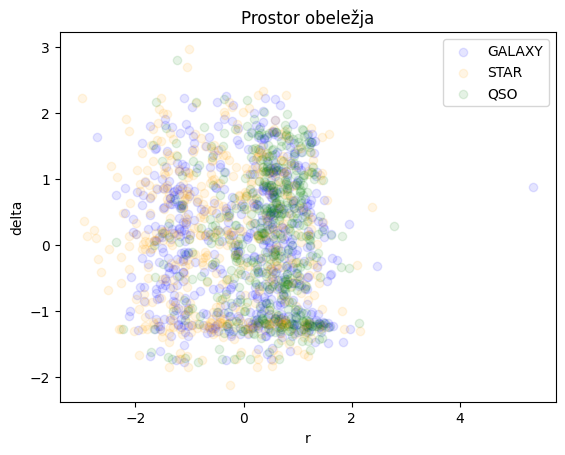

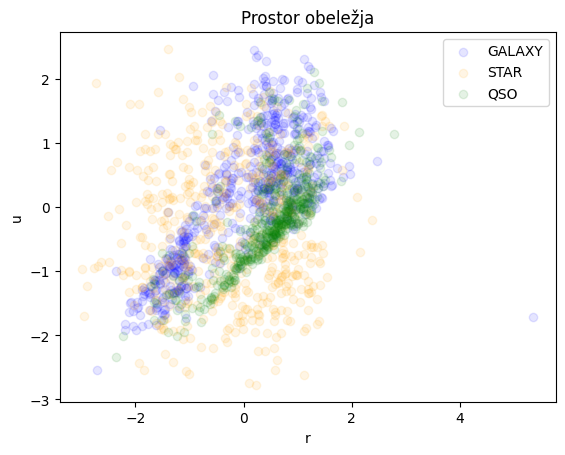

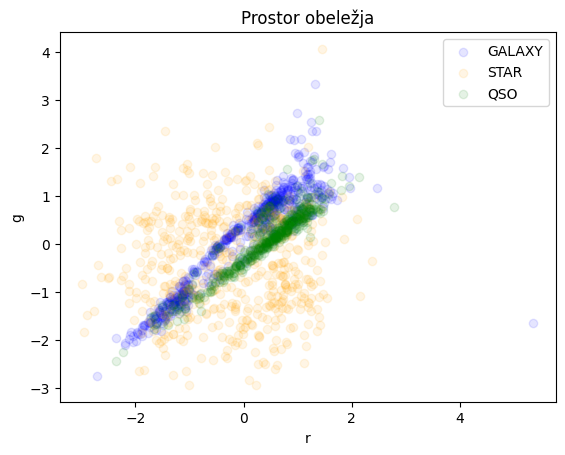

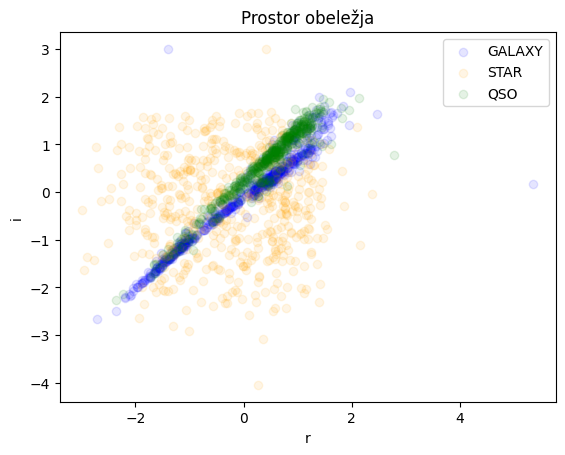

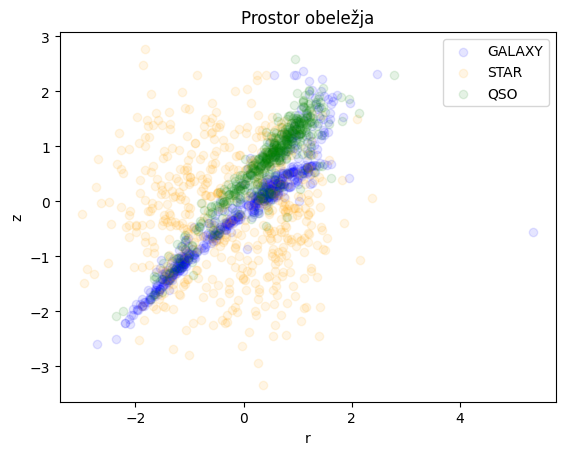

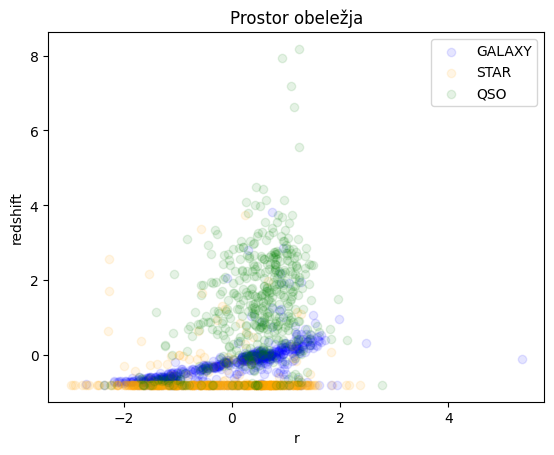

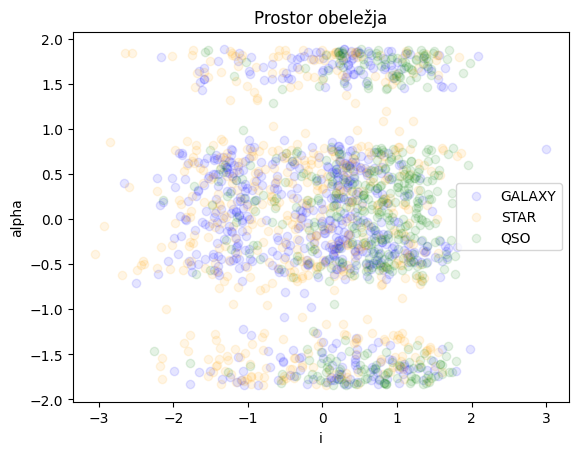

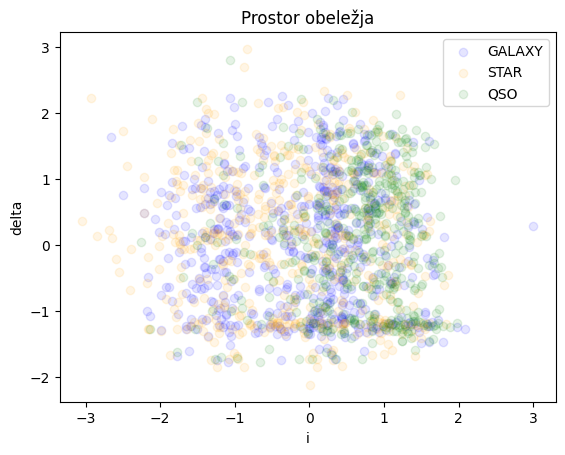

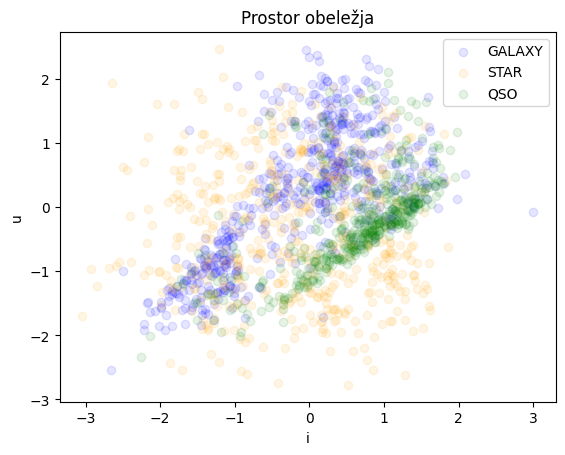

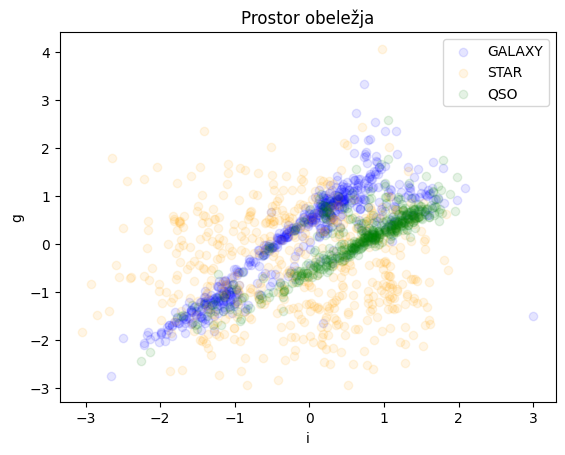

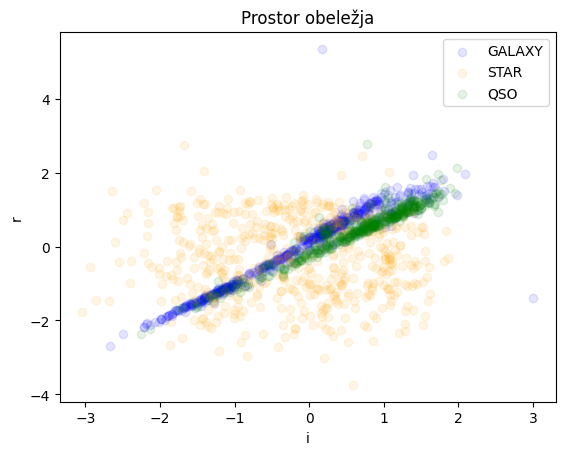

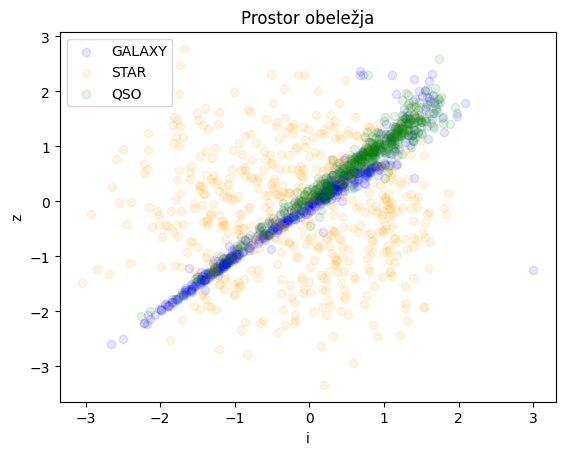

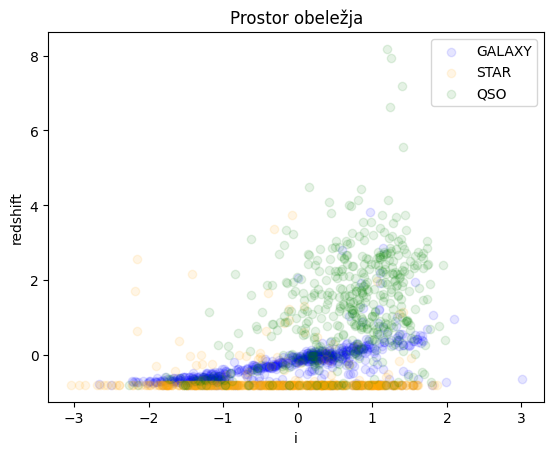

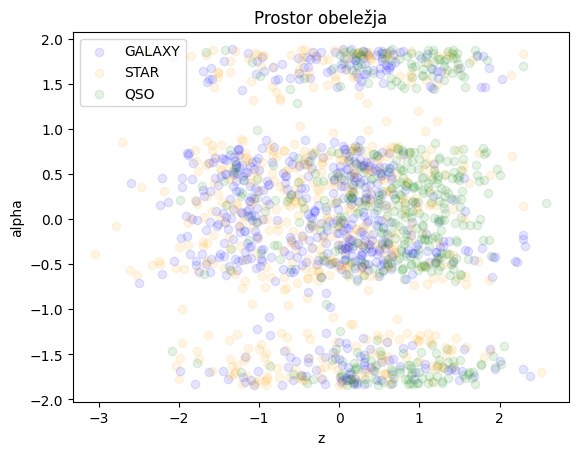

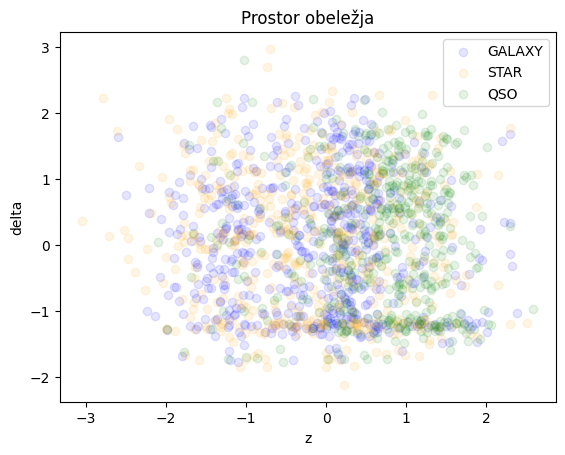

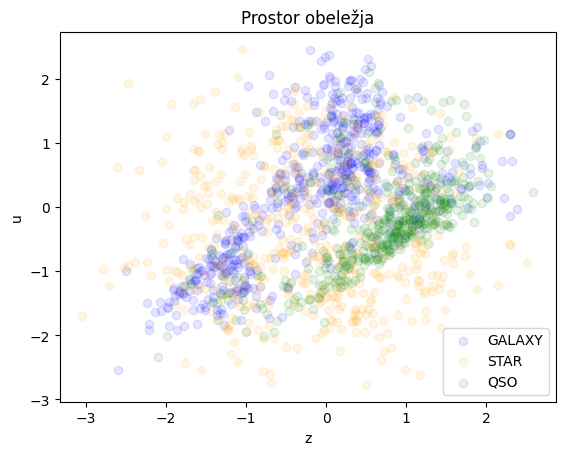

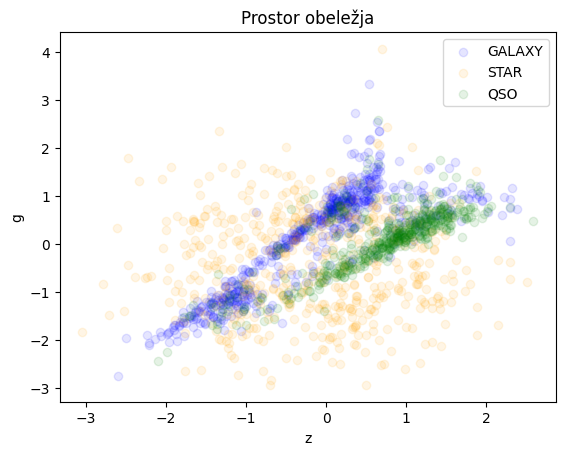

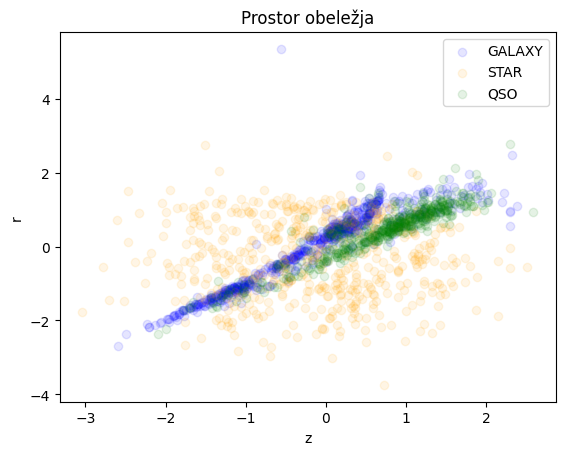

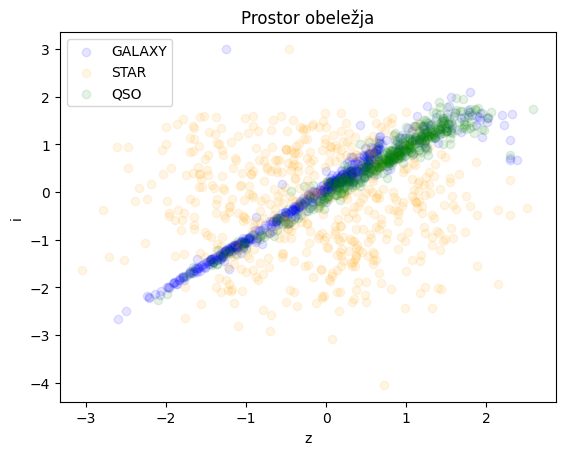

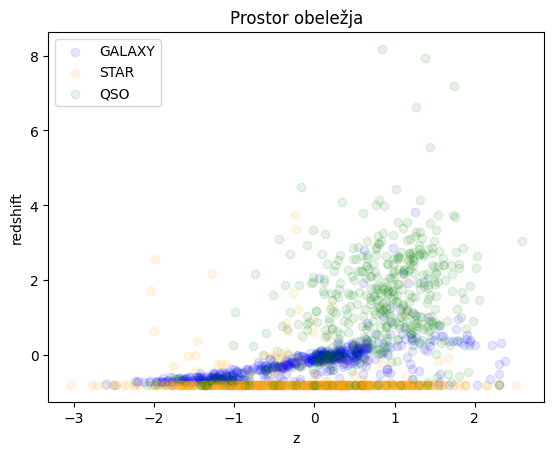

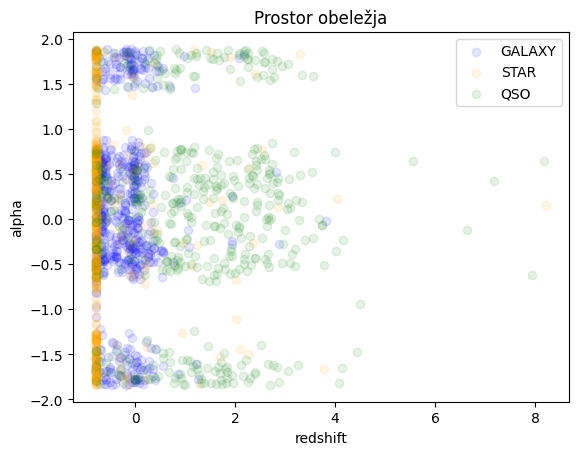

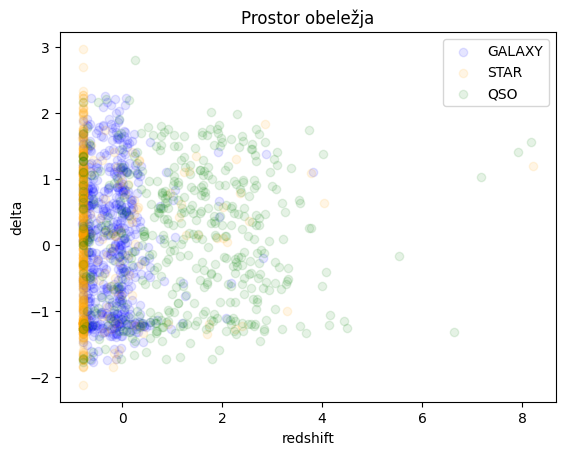

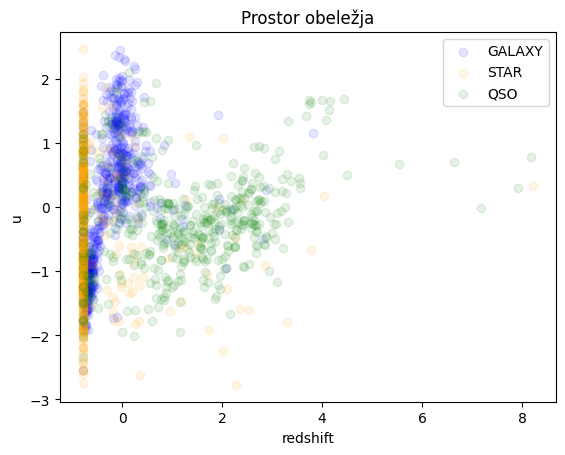

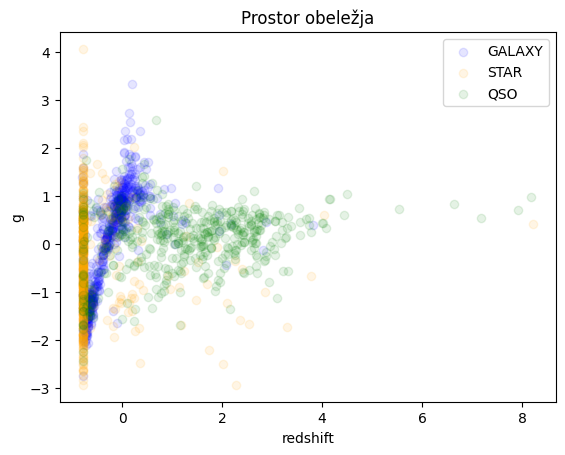

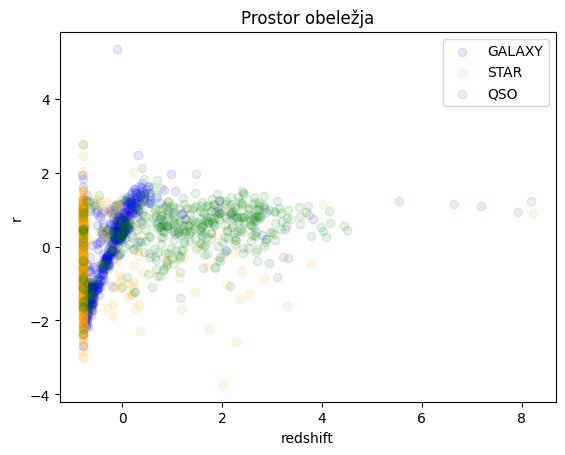

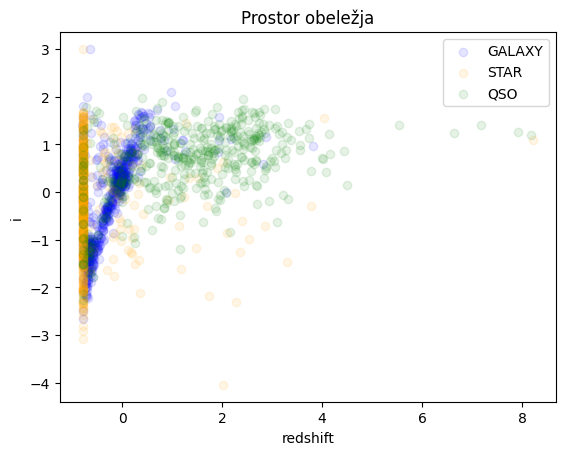

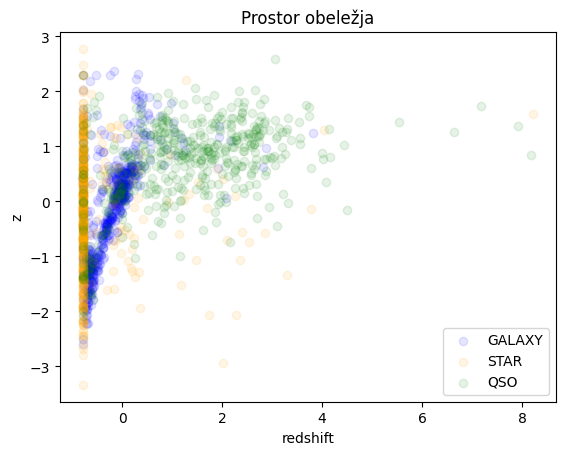

In [10]:
scaler = StandardScaler()
x1 = scaler.fit_transform(x)
x1 = pd.DataFrame(x1,columns = x.columns)
x1['class'] = df['class']
columns = x.columns
for i in range(len(columns)):
  for j in range(len(columns)):
    if i==j:
      continue
    plt.scatter(x1.loc[ x1['class']=='GALAXY', columns[i] ].sample(frac=0.01, random_state=42),x1.loc[ x1['class']=='GALAXY', columns[j] ].sample(frac=0.01, random_state=42),color='blue',label='GALAXY',alpha=0.1)
    plt.scatter(x1.loc[ x1['class']=='STAR', columns[i] ].sample(frac=0.025, random_state=42),x1.loc[ x1['class']=='STAR', columns[j] ].sample(frac=0.025, random_state=45),color='orange',label='STAR',alpha=0.1)
    plt.scatter(x1.loc[ x1['class']=='QSO', columns[i] ].sample(frac=0.025, random_state=42),x1.loc[ x1['class']=='QSO', columns[j] ].sample(frac=0.025, random_state=42),color='green',label='QSO',alpha=0.1)
    plt.title('Prostor obeležja')
    plt.xlabel(columns[i])
    plt.ylabel(columns[j])
    plt.legend()
    plt.show()

##Zaključak analize podataka
Na osnovu analize, zaključujemo da su dobri vektori r i redshift, dok su recimo delta i alpha loši.

#Modeli

##kNN

###Implementacija
Za kNN, napravićemo 3 modela. Mjerićemo njihovu **učinkovitost** i **vrijeme** treniranja.
1. model će koristiti dobre obeležja
2. model će koristiti loša obeležja
3. model će koristiti sva obeležja

1. model

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

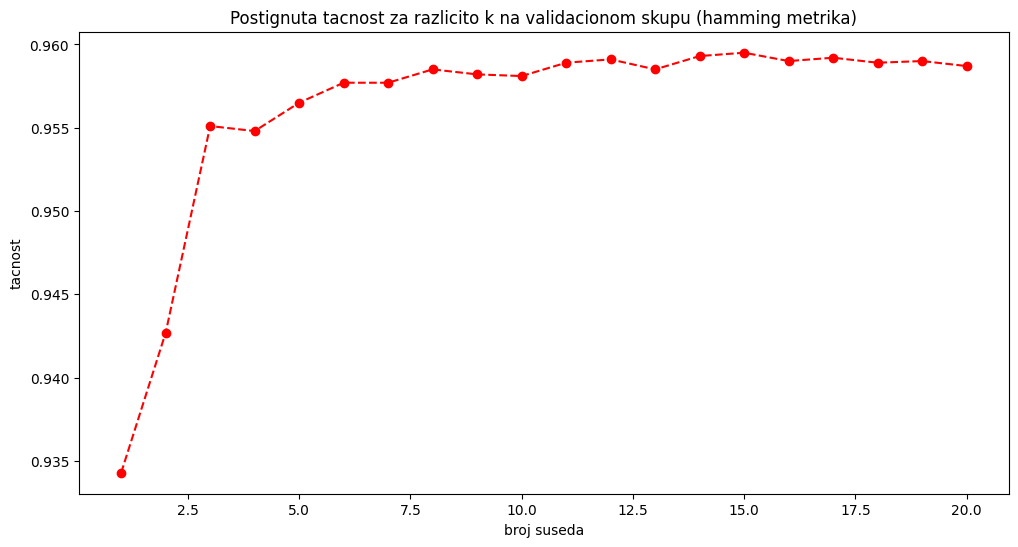


Vrijeme za koje je bilo neophodno da se iztrenira model:  15.225888013839722 s
Accuracy: 0.9551
              precision    recall  f1-score   support

      GALAXY       0.95      0.97      0.96      5945
         QSO       0.95      0.86      0.90      1896
        STAR       0.96      1.00      0.98      2159

    accuracy                           0.96     10000
   macro avg       0.96      0.94      0.95     10000
weighted avg       0.96      0.96      0.95     10000

Confusion matrix:
[[5770   81   94]
 [ 270 1625    1]
 [   3    0 2156]]


In [11]:
x1 = x[['r','redshift']]
scaler = StandardScaler()
x1 = scaler.fit_transform(x1)
x1 = pd.DataFrame(x1,columns = ['r','redshift'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(x1, y, train_size=0.8, random_state=10, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=10, stratify=y_test)
acc = []
# Racunanje greske za razlicito k, hamming metrika

t1 = time.time()
for i in range(1, 21):
    print(i,end=" ")
    classifier = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    acc.append(metrics.accuracy_score(y_val, y_pred))
t2 = time.time()
t_1  = t2 - t1
plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), acc, color='red', linestyle='dashed', marker='o')
plt.title('Postignuta tacnost za razlicito k na validacionom skupu (hamming metrika)')
plt.xlabel('broj suseda')
plt.ylabel('tacnost')
plt.show()
print()
print('Vrijeme za koje je bilo neophodno da se iztrenira model: ',t_1,'s')

classifier1 = KNeighborsClassifier(n_neighbors=15, metric='euclidean')
classifier1.fit(pd.concat([X_train, X_val], axis=0), pd.concat([y_train, y_val], axis=0))
y_pred = classifier1.predict(X_test)

acc1 = metrics.accuracy_score(y_test,y_pred)
report1 = metrics.classification_report(y_test, y_pred)
conf_mat1 = metrics.confusion_matrix(y_test, y_pred)
print('Accuracy:',acc1)
print(report1)
print('Confusion matrix:')
print(conf_mat1)

2. model

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

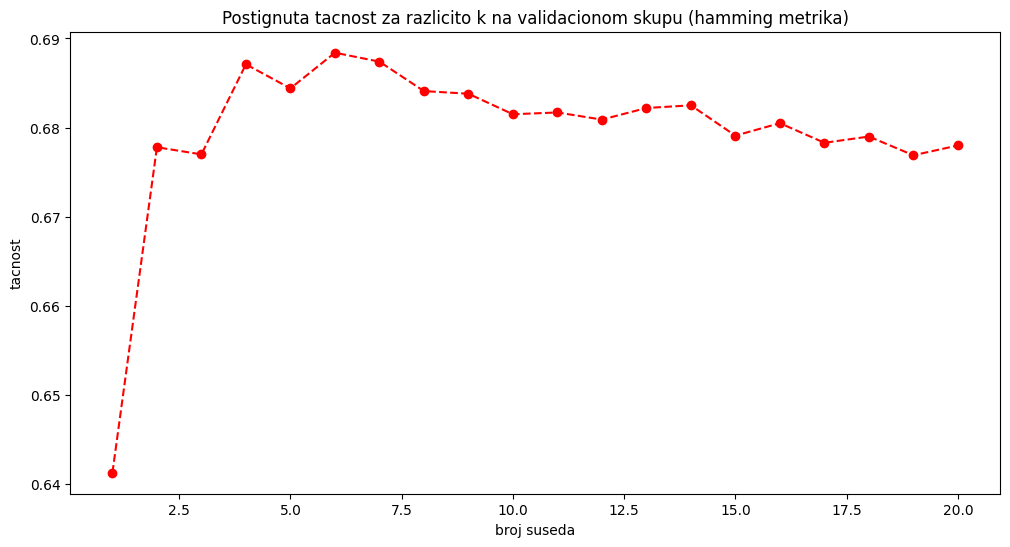


Vrijeme za koje je bilo neophodno da se iztrenira model:  15.576441049575806 s
Accuracy: 0.6801
              precision    recall  f1-score   support

      GALAXY       0.75      0.89      0.81      5945
         QSO       0.46      0.34      0.39      1896
        STAR       0.58      0.41      0.48      2159

    accuracy                           0.68     10000
   macro avg       0.59      0.55      0.56     10000
weighted avg       0.66      0.68      0.66     10000

Confusion matrix:
[[5271  354  320]
 [ 920  649  327]
 [ 871  407  881]]


In [12]:
x2 = x[['delta','alpha']]
scaler = StandardScaler()
x2 = scaler.fit_transform(x2)
x2 = pd.DataFrame(x2,columns = ['delta','alpha'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(x2, y, train_size=0.8, random_state=10, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=10, stratify=y_test)
acc = []
# Racunanje greske za razlicito k, hamming metrika

t1 = time.time()
for i in range(1, 21):
    print(i,end=" ")
    classifier = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    acc.append(metrics.accuracy_score(y_val, y_pred))
t2 = time.time()
t_2  = t2 - t1
plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), acc, color='red', linestyle='dashed', marker='o')
plt.title('Postignuta tacnost za razlicito k na validacionom skupu (hamming metrika)')
plt.xlabel('broj suseda')
plt.ylabel('tacnost')
plt.show()
print()
print('Vrijeme za koje je bilo neophodno da se iztrenira model: ',t_2,'s')

classifier2 = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
classifier2.fit(pd.concat([X_train, X_val], axis=0), pd.concat([y_train, y_val], axis=0))
y_pred = classifier2.predict(X_test)

acc2 = metrics.accuracy_score(y_test,y_pred)
report2 = metrics.classification_report(y_test, y_pred)
conf_mat2 = metrics.confusion_matrix(y_test, y_pred)
print('Accuracy:',acc2)
print(report2)
print('Confusion matrix:')
print(conf_mat2)

3. model

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

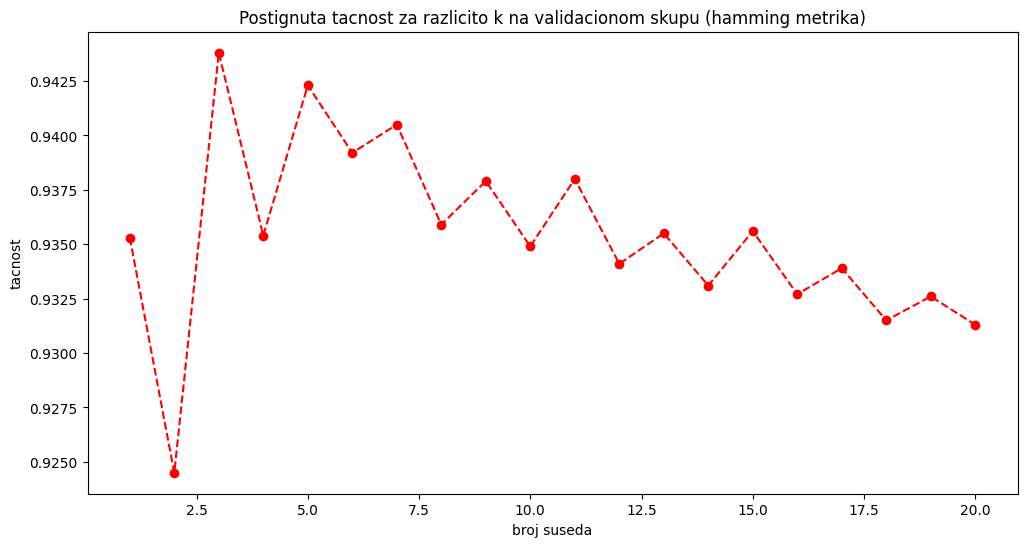


Vrijeme za koje je bilo neophodno da se iztrenira model:  39.469178199768066 s
Accuracy: 0.9353
              precision    recall  f1-score   support

      GALAXY       0.95      0.95      0.95      5945
         QSO       0.95      0.92      0.94      1896
        STAR       0.89      0.91      0.90      2159

    accuracy                           0.94     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.94      0.94      0.94     10000

Confusion matrix:
[[5640   84  221]
 [ 139 1743   14]
 [ 188    1 1970]]


In [13]:
x3 = x
scaler = StandardScaler()
x3 = scaler.fit_transform(x3)
x3 = pd.DataFrame(x3,columns = x.columns)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(x3, y, train_size=0.8, random_state=10, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=10, stratify=y_test)
acc = []
# Racunanje greske za razlicito k, hamming metrika

t1 = time.time()
for i in range(1, 21):
    print(i,end=" ")
    classifier = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    acc.append(metrics.accuracy_score(y_val, y_pred))
t2 = time.time()
t_3  = t2 - t1
plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), acc, color='red', linestyle='dashed', marker='o')
plt.title('Postignuta tacnost za razlicito k na validacionom skupu (hamming metrika)')
plt.xlabel('broj suseda')
plt.ylabel('tacnost')
plt.show()
print()
print('Vrijeme za koje je bilo neophodno da se iztrenira model: ',t_3,'s')

classifier3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
classifier3.fit(pd.concat([X_train, X_val], axis=0), pd.concat([y_train, y_val], axis=0))
y_pred = classifier3.predict(X_test)

acc3 = metrics.accuracy_score(y_test,y_pred)
report3 = metrics.classification_report(y_test, y_pred)
conf_mat3 = metrics.confusion_matrix(y_test, y_pred)
print('Accuracy:',acc3)
print(report3)
print('Confusion matrix:')
print(conf_mat3)

###Rezultati
Možemo da vidimo da odabirom isključivo dobrih obeležja za kNN možemo za nijansu da povećamo preciznost i prepolovimo vrijeme treninga. Ukoliko odaberemo sva obeležja kNN će dobro klasifikovati, ali vrijeme treninga će biti duže. Trening se smatra odabir odgovarajućeg k.
Smanjivanjem broja obeležja na isključivo dobre, smanjujemo vrijeme treninga.

In [14]:
print('Preciznost modela')
print('1. model:',acc1)
print('2. model:',acc2)
print('3. model:',acc3)
print()
print('Vrijeme modela')
print('1. model:',t_1)
print('2. model:',t_2)
print('3. model:',t_3)

Preciznost modela
1. model: 0.9551
2. model: 0.6801
3. model: 0.9353

Vrijeme modela
1. model: 15.225888013839722
2. model: 15.576441049575806
3. model: 39.469178199768066


##Logistička regresija
U skicit learn-u logisti;ka regresija podržava funkciju greške za l1 i l2 normu. Podržava multinomial logističku regresiju koju nije neophodno eksplicitno navoditi. Ima nekoliko solvera(nzm šta su tačno ti solveri), "liblinear", za manje dataskupove i binarnu klasifikaciju i "saga" za veće data skupove i binarnu i multinomialnu klasifikaciju. Dodatno u polje multi_class može da se odabere "ovr" to je valjda za binarno i "multinomial" to je sa više klasa.

###Ovde cu napisati sta radim u nastavku
1. model sa svim obeležijima
2. model sa **dobrim** obeležijima
3. model sa **normalizovanim** obeležijima
4. model sa **dobrim** i **normalizovanim** obeležijima

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=10, stratify=y)


lg1 = LogisticRegression(solver='saga')                         #saga je dobar za velike skupove i viseklasnu klasifikaciju
t1 = time.time()
lg1.fit(X_train,y_train)
t2 = time.time()
t_1 = t2-t1
y_pred = lg1.predict(X_test)

acc1 = metrics.accuracy_score(y_test,y_pred)
t_1 = t2-t1

model_results(y_pred,y_test,t_1)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Vrijeme za koje je bilo neophodno da se iztrenira model:  7.223922252655029 s
Accuracy: 0.87045
              precision    recall  f1-score   support

      GALAXY       0.92      0.87      0.89     12486
         QSO       0.88      0.94      0.91      3556
        STAR       0.74      0.80      0.77      3958

    accuracy                           0.87     20000
   macro avg       0.84      0.87      0.86     20000
weighted avg       0.87      0.87      0.87     20000

Confusion matrix:
[[10901   447  1138]
 [  227  3328     1]
 [  761    17  3180]]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(x[['r','redshift']], y, train_size=0.8, random_state=10, stratify=y)

lg2 = LogisticRegression(solver='saga')                         #saga je dobar za velike skupove i viseklasnu klasifikaciju
t1 = time.time()
lg2.fit(X_train,y_train)
t2 = time.time()
t_2 = t2-t1
y_pred = lg2.predict(X_test)

acc2 = metrics.accuracy_score(y_test,y_pred)
t_2 = t2-t1

model_results(y_pred,y_test,t_2)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Vrijeme za koje je bilo neophodno da se iztrenira model:  4.820300817489624 s
Accuracy: 0.9443
              precision    recall  f1-score   support

      GALAXY       0.96      0.95      0.95     12110
         QSO       0.82      0.96      0.89      3250
        STAR       1.00      0.93      0.96      4640

    accuracy                           0.94     20000
   macro avg       0.93      0.95      0.93     20000
weighted avg       0.95      0.94      0.95     20000

Confusion matrix:
[[11444   666     0]
 [  123  3125     2]
 [  322     1  4317]]


In [17]:
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)
x_norm = pd.DataFrame(x_norm,columns = x.columns)

X_train, X_test, y_train, y_test = train_test_split(x_norm, y, train_size=0.8, random_state=10, stratify=y)

lg3 = LogisticRegression(solver='saga')                         #saga je dobar za velike skupove i viseklasnu klasifikaciju
t1 = time.time()
lg3.fit(X_train,y_train)
t2 = time.time()
t_3 = t2-t1
y_pred = lg3.predict(X_test)

acc3 = metrics.accuracy_score(y_test,y_pred)
t_3 = t2-t1

model_results(y_pred,y_test,t_3)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Vrijeme za koje je bilo neophodno da se iztrenira model:  7.354818820953369 s
Accuracy: 0.9556
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     11887
         QSO       0.88      0.95      0.91      3543
        STAR       1.00      0.94      0.97      4570

    accuracy                           0.96     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.96      0.96      0.96     20000

Confusion matrix:
[[11445   441     1]
 [  192  3350     1]
 [  252     1  4317]]


In [18]:
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)
x_norm = pd.DataFrame(x_norm,columns = x.columns)

X_train, X_test, y_train, y_test = train_test_split(x_norm[['r','redshift']], y, train_size=0.8, random_state=10, stratify=y)

lg4 = LogisticRegression(solver='saga')                         #saga je dobar za velike skupove i viseklasnu klasifikaciju
t1 = time.time()
lg4.fit(X_train,y_train)
t2 = time.time()
t_4 = t2-t1
y_pred = lg4.predict(X_test)

acc4 = metrics.accuracy_score(y_test,y_pred)
t_4 = t2-t1

model_results(y_pred,y_test,t_4)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Vrijeme za koje je bilo neophodno da se iztrenira model:  4.6565470695495605 s
Accuracy: 0.94825
              precision    recall  f1-score   support

      GALAXY       0.97      0.95      0.96     12171
         QSO       0.83      0.96      0.89      3261
        STAR       1.00      0.95      0.97      4568

    accuracy                           0.95     20000
   macro avg       0.93      0.95      0.94     20000
weighted avg       0.95      0.95      0.95     20000

Confusion matrix:
[[11514   657     0]
 [  125  3134     2]
 [  250     1  4317]]


###Rezultati
U našem eksperimentu normalizacija ili korišćenje isključivo dobrih obeležja povećavaju preciznost za nepuno 10%.
Korišćenje manjeg broja obeležja smanjuje duplo vrijeme treninga

In [19]:
print('Preciznost modela')
print('1. model:',acc1)
print('2. model:',acc2)
print('3. model:',acc3)
print('4. model:',acc4)
print()
print('Vrijeme modela')
print('1. model:',t_1)
print('2. model:',t_2)
print('3. model:',t_3)
print('4. model:',t_4)

Preciznost modela
1. model: 0.87045
2. model: 0.9443
3. model: 0.9556
4. model: 0.94825

Vrijeme modela
1. model: 7.223922252655029
2. model: 4.820300817489624
3. model: 7.354818820953369
4. model: 4.6565470695495605


###Pregled koeficijenata


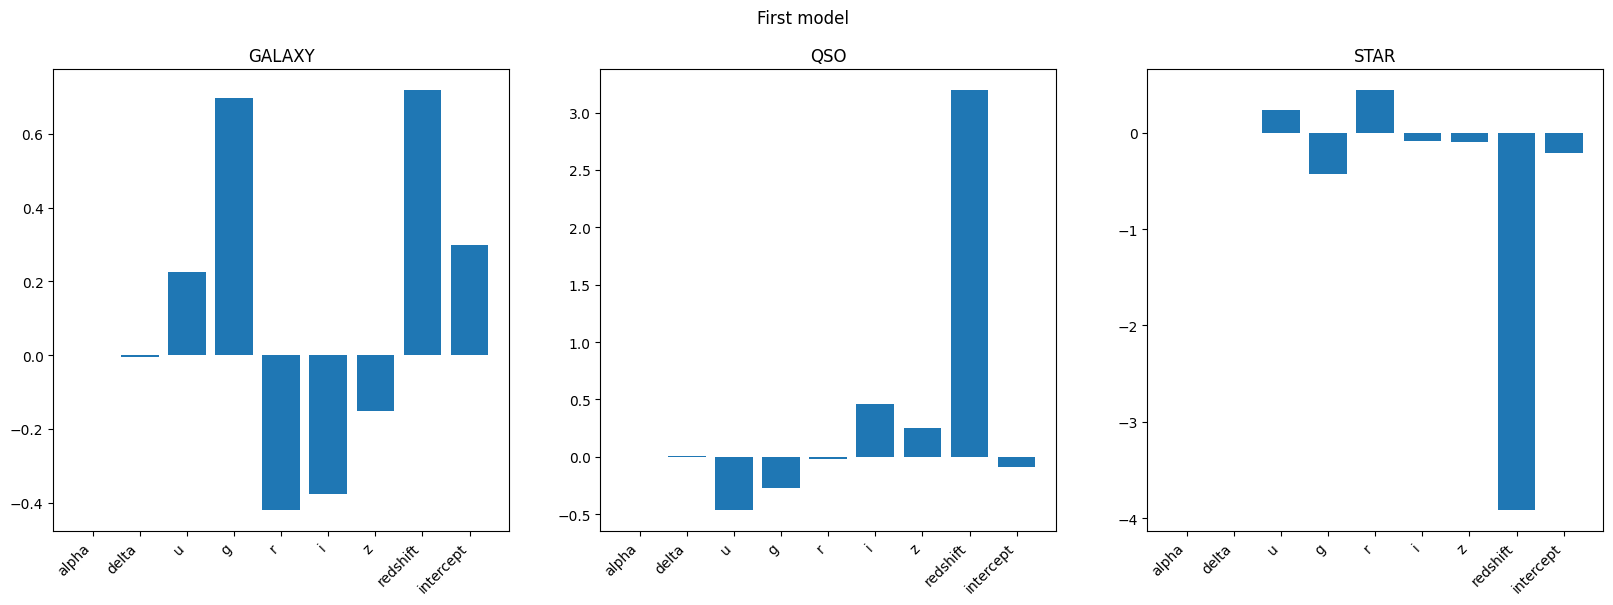

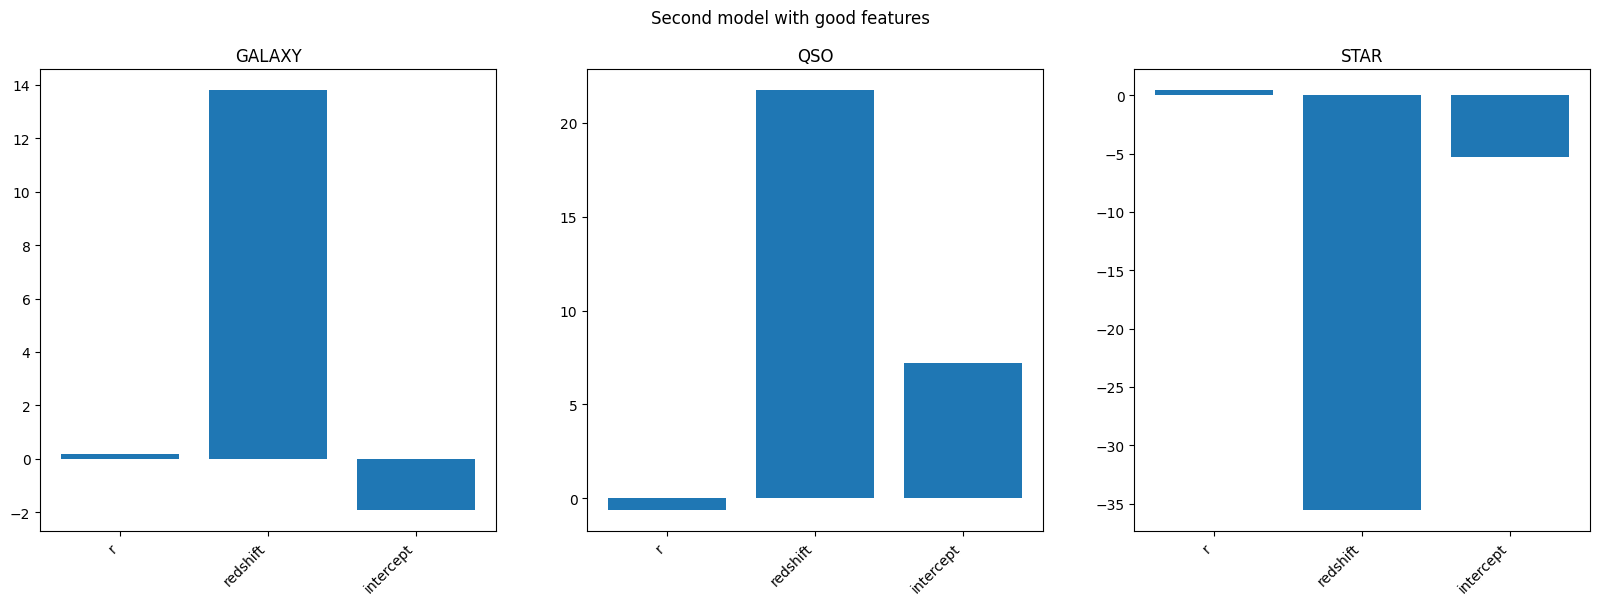

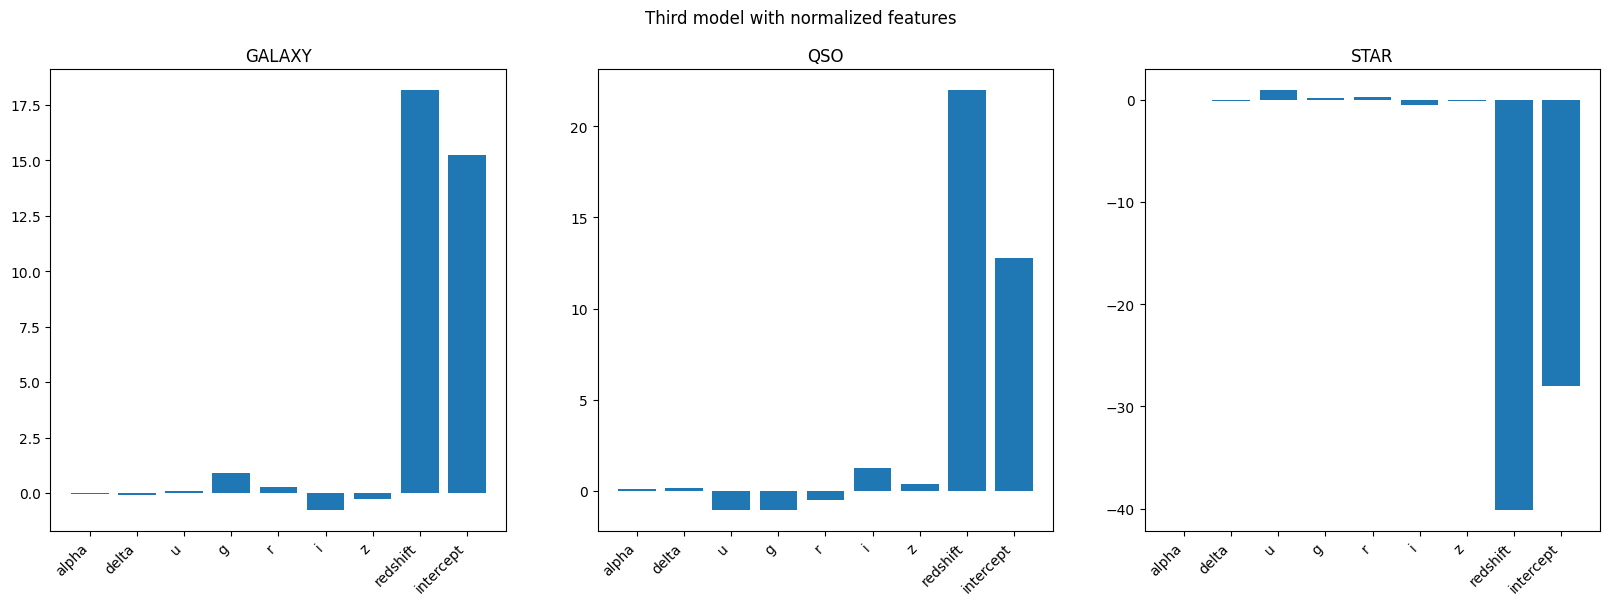

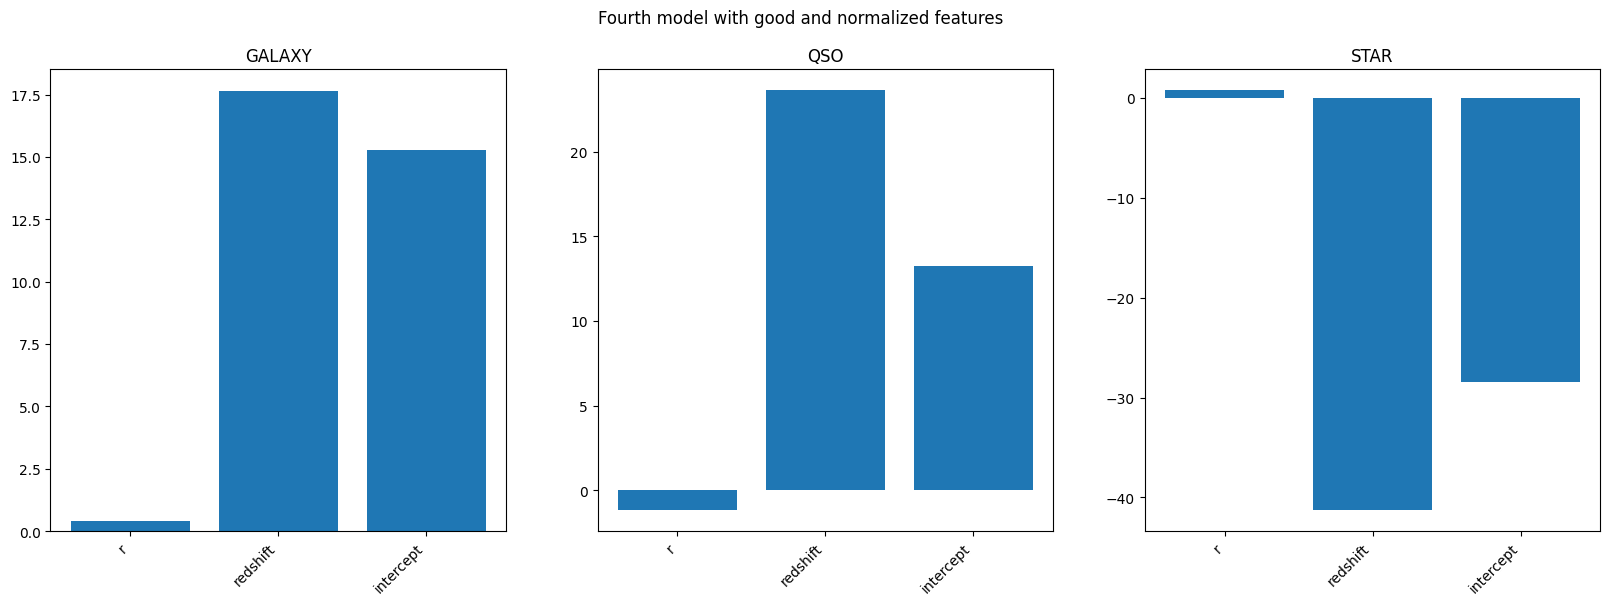

In [20]:
def show_coef_of_all_models(lg,columns,t):
  weights = []
  plt.figure(figsize=(20,6))
  for i in range(3):
    classes = lg.classes_
    weights.append(lg.coef_[i])
    weights[i] = np.append(weights[i],lg.intercept_[i])


    plt.subplot(1,3,i+1)
    plt.bar(np.append(columns,'intercept'),weights[i])
    plt.xticks(rotation=45,ha='right')
    plt.title(classes[i])
  plt.suptitle(t)
  plt.show()

t = ["A","B","C","D"]
lgs = [lg1,lg2,lg3,lg4]
show_coef_of_all_models(lg1,x.columns,"First model")
show_coef_of_all_models(lg2,['r','redshift'],"Second model with good features")
show_coef_of_all_models(lg3,x.columns,"Third model with normalized features")
show_coef_of_all_models(lg4,['r','redshift'],"Fourth model with good and normalized features")